# Predicting house prices : regression.

## Loading Boston house prices data.

In [6]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

look at the data:

In [7]:
print(train_data.shape)
print(train_targets.shape)
print(test_data.shape)
print(train_data[0])
print(train_targets[0])

(404, 13)
(404,)
(102, 13)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


## Preparing the data.

normalizing the data

In [8]:
mean = train_data.mean(axis=0) #对每列求平均
train_data -= mean
std = train_data.std(axis=0) #对每列取标准差
train_data /= std
test_data -= mean
test_data /= std

## Building models.

In [10]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

## Validating your approach using K-fold validation

In [12]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]], axis = 0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [14]:
print(all_scores)
print(np.mean(all_scores))

[1.9293500185012817, 2.712942600250244, 2.810431718826294, 2.326080560684204]
2.444701224565506


## saving the validation logs at each fold.

In [16]:
num_epochs = 500
all_mae_history = []
for i in range(k):
    print('proceing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]], axis = 0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data = (val_data, val_targets), epochs = num_epochs, batch_size = 1, verbose = 0)
    mae_history = history.history['val_mae']
    all_mae_history.append(mae_history)

proceing fold # 0
proceing fold # 1
proceing fold # 2
proceing fold # 3


Building the history of successive mean K-fold validation scores

In [17]:
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)] # all_mae_history 包含四个500维的列向量，np.mean是对每个i对应的四个值(k=0,1,2,3)求一次平均

Plotting validation scores

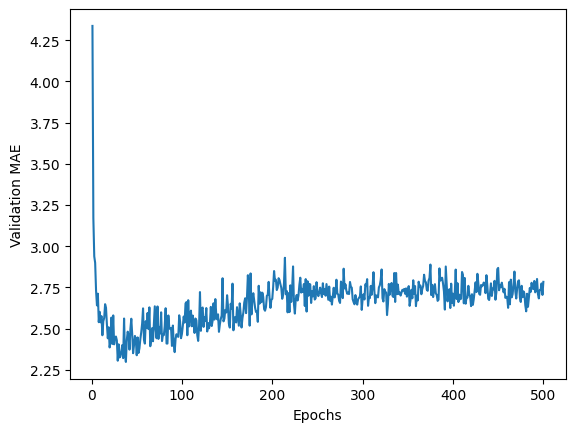

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Plotting validation scores, excluding the first 10 data points.
```
It may be a little difficult to see the plot, due to scaling issues and relatively high variance.
Let’s do the following:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points,
to obtain a smooth curve.
```

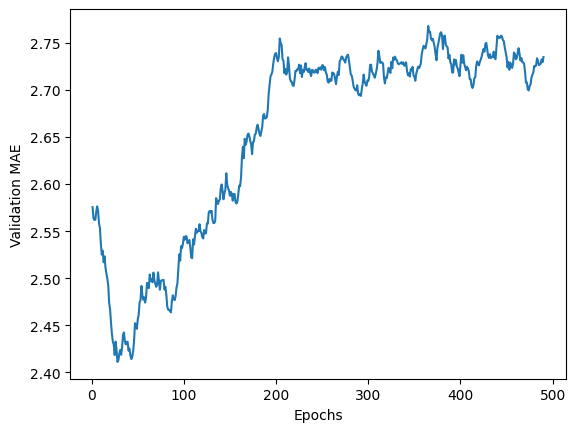

In [19]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

train final model
```
According to this plot, validation MAE stops improving significantly after 80 epochs.
Past that point, you start overfitting.
Once you’re finished tuning other parameters of the model (in addition to the
number of epochs, you could also adjust the size of the hidden layers), you can train a
final production model on all of the training data, with the best parameters, and then
look at its performance on the test data.
```

In [20]:
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 17.5868 - mae: 2.5366


In [21]:
print(test_mae_score)

2.536637544631958
